In [2]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [14]:
data = pd.read_csv('C:/Users/luizf/Desktop/MINDS/Datasets/HomeC.csv', sep=',')
data = data.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
#data = data.loc[0: : 10]
X=data.copy()
X.drop(data.tail(2).index,inplace=True)
X.reset_index(inplace=True)
X.drop('index', axis=1, inplace=True)
y=data.copy()
y.loc[max(y.index)+1, :] = None
y=y.shift(-1)
y.dropna(inplace=True)
y

C:\Users\luizf\miniconda3\envs\test\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.934333,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
1,0.931817,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
2,1.022050,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
3,1.139400,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
4,1.391867,0.003433,0.000283,0.503250,0.063667,0.447033,0.122300,0.006717,0.012433,0.000483,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503904,1.601233,0.003183,0.000050,0.085267,0.642417,0.041783,0.005267,0.008667,0.013483,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503905,1.599333,0.003233,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503906,1.924267,0.003217,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503907,1.978200,0.003217,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51


In [4]:
X.columns[1]

'gen [kW]'

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [29]:
def train_lstm(X_train, layer_dim, dropout_prob, epochs, batch_size, learning_rate, step_wdecay, gamma_wdecay, X_val=0):
    train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=batch_size, shuffle=False)
    #val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=batch_size,shuffle=False)
    if torch.cuda.is_available():
        y_train_t= torch.tensor(y_train.astype(np.float32)).cuda()
    #    y_val_t = torch.tensor(y_val.astype(np.float32)).cuda()
    else:
        y_train_t = torch.tensor(y_train.astype(np.float32))
    #    y_val_t = torch.tensor(y_val.astype(np.float32))
    torch.manual_seed(1)
    alpha = 0.5
    h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
    model = LSTMModel(X_train.shape[1],h, layer_dim,X_train.shape[1],dropout_prob)
    if torch.cuda.is_available():
        model = model.cuda()
    else:
        model = model.cuda()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    buffer = 10000
    steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_wdecay, gamma=gamma_wdecay)

    min_valid_loss=500
    for epoch in range(epochs):
        aux,aux2=0,0
        train_loss=0.0
        model.train()
        for batch, d in enumerate(train_loader):
            if torch.cuda.is_available():
                d =d.cuda()
            optimizer.zero_grad()  #set gradient to 0
            output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
            if torch.cuda.is_available():
                loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
            else:
                loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
            loss.backward()  #differentiate loss with respect to parameters
            optimizer.step() #apply the method step and updates the parameters 
            train_loss += loss.item()
            aux+=d.shape[0]
        steplr.step()

        #valid_loss = 0.0
        #model.eval() 
        #for dv in val_loader:  
        #    if torch.cuda.is_available():
        #        dv =dv.cuda()  
        #    target = model(dv.unsqueeze(1))
        #    if torch.cuda.is_available():
        #        val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        #    else:
        #        val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        #    valid_loss += val_loss.item()
        #    aux2+=dv.shape[0]
        #print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        #if valid_loss < buffer:
        #    buffer = valid_loss
#
   # print (buffer/len(val_loader))   
    return model

In [30]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [35]:
n_windows = 30
w = round(len(X)/n_windows)
buffer =  {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape":[],
         "nrmse":[],
         "variable":[]
    }
    
col = ["window","rmse","mape","mae","r2","variable"]
result = pd.DataFrame(columns=col)
a={}
for i in range(n_windows):
    dfx=X.iloc[int(w*i):int(w*(i+1)), :]
    dfy=y.iloc[int(w*i):int(w*(i+1)), :]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train, X_test = train_test_split(dfx, test_size=0.25, shuffle=False)
    #X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
    X_train = scaler.fit_transform(X_train.values)
    #X_val = scaler.fit_transform(X_val.values)


    y_train, y_test = train_test_split(dfy, test_size=0.25, shuffle=False)
    #y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
    y_train = scaler.fit_transform(y_train.values)
    #y_val = scaler.fit_transform(y_val.values)

    model = train_lstm(X_train, layer_dim=2, dropout_prob=0, epochs=200, batch_size=64, learning_rate=0.001, step_wdecay=90, gamma_wdecay=0.1)

    model.eval()
    if torch.cuda.is_available():
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
    else:
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
    y_norm = scaler.fit_transform(y_test.values)
    #yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
    yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().cpu().numpy())
    #y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]
    
    from pyFTS.benchmarks import Measures
    buffer['rmse']=[Measures.rmse(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mape']=[Measures.mape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mae']=[mean_absolute_error(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['r2']=[r2_score(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['smape']=[Measures.smape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['nrmse']=[cal_nrmse(Measures.rmse(y_test.values[:,j],yhat[:,j]),y_test.values[:,j]) for j in range (X.shape[1])]
    buffer['variable']=[j for j in X.columns]
    buffer['window']= w*i

    result = pd.concat([result, pd.DataFrame(buffer)], ignore_index=True)
    #result['rmse'].append([j for j in buffer['rmse']])
    #result['mape'].append(buffer['mape'])
    #result['mae'].append(buffer['mae'])
    #result['r2'].append(buffer['r2'])
    #result['variable'].append([j for j in X.columns])
    #result['window'].append(buffer['window'])
#
#result = np.mean(buffer)
#print (result)


    
    


<generator object Module.parameters at 0x0000014D1F376B30>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376D60>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376CF0>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376C80>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376B30>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376D60>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376CF0>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376C80>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376B30>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\AppData\Local\Temp/ipykernel_20756/1568283450.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (rmse/x)


<generator object Module.parameters at 0x0000014D1F376D60>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376CF0>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\AppData\Local\Temp/ipykernel_20756/1568283450.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (rmse/x)


<generator object Module.parameters at 0x0000014D1F376C80>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376B30>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376D60>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376CF0>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376C80>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376B30>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376D60>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\AppData\Local\Temp/ipykernel_20756/1568283450.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (rmse/x)


<generator object Module.parameters at 0x0000014D1F376CF0>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376C80>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376B30>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376D60>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376CF0>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376C80>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376510>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376D60>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376CF0>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376C80>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376510>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100


<generator object Module.parameters at 0x0000014D1F376D60>


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:90: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(np.abs(forecasts - targets) / (np.abs(forecasts) + abs(targets))) * 100


In [36]:
result

,window,rmse,mape,mae,r2,variable,smape,nrmse
0,0,0.339910,20.193985,0.205515,0.763844,use [kW],9.612449,0.075057
1,0,0.030396,inf,0.014398,0.843227,gen [kW],49.050419,0.056879
2,0,0.074793,inf,0.028895,0.888749,Dishwasher [kW],92.174563,0.054680
3,0,0.097907,125.375959,0.062897,0.777726,Furnace 1 [kW],27.725227,0.064081
4,0,0.099291,39.894796,0.052954,0.820117,Furnace 2 [kW],15.291063,0.148984
...,...,...,...,...,...,...,...,...
805,487113,0.646297,9.884975,0.460254,0.969171,windSpeed,4.771422,0.044480
806,487113,21.563038,15.949710,13.794040,0.924737,windBearing,4.649514,0.063421
807,487113,0.002681,inf,0.001314,0.931168,precipIntensity,78.919931,0.057418
808,487113,1.621590,5.889908,1.407423,0.830535,dewPoint,2.913039,0.119586


In [37]:
final_measures = {'variable':[], 'rmse': [], 'mae': [], 'mape': [], 'r2': [], 'smape':[], 'nrmse':[], 'rmse_std': [], 'mae_std': [], 'mape_std': [], 'r2_std': [], 'smape_std':[], 'nrmse_std':[]}
m=[]
for i in list(X.columns):
    m=result[result.variable==i].mean()
    st = result[result.variable==i].std()
    final_measures['variable'].append(i)
    final_measures['rmse'].append(m['rmse'])
    final_measures['mae'].append(m['mae'])
    final_measures['mape'].append(m['mape'])
    final_measures['r2'].append(m['r2'])
    final_measures['smape'].append(m['smape'])
    final_measures['nrmse'].append(m['nrmse'])
    final_measures['rmse_std'].append(st['rmse'])
    final_measures['mae_std'].append(st['mae'])
    final_measures['mape_std'].append(st['mape'])
    final_measures['r2_std'].append(st['r2'])
    final_measures['smape_std'].append(st['smape'])
    final_measures['nrmse_std'].append(st['nrmse'])
pd.DataFrame(final_measures)

C:\Users\luizf\AppData\Local\Temp/ipykernel_20756/2831257117.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m=result[result.variable==i].mean()
C:\Users\luizf\AppData\Local\Temp/ipykernel_20756/2831257117.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  st = result[result.variable==i].std()


,variable,rmse,mae,mape,r2,smape,nrmse,rmse_std,mae_std,mape_std,r2_std,smape_std,nrmse_std
0,use [kW],0.466377,0.287085,180.509745,0.245966,18.840165,0.068667,0.311994,0.190630,214.530481,1.621158,9.671655,0.030837
1,gen [kW],0.031025,0.018552,inf,0.921624,39.172203,0.064876,0.012341,0.009112,NaN,0.046011,8.563241,0.024377
2,Dishwasher [kW],0.068254,0.028749,inf,0.802579,95.266652,0.056229,0.017542,0.011064,NaN,0.246923,1.747784,0.026553
3,Furnace 1 [kW],0.065187,0.033514,69.182266,0.675896,26.127327,0.080526,0.028522,0.019447,42.932419,0.342526,16.930080,0.044454
4,Furnace 2 [kW],0.062676,0.038192,34.543620,0.716730,15.457881,0.109183,0.041237,0.028016,25.435364,0.231074,13.742060,0.043766
5,Home office [kW],0.022697,0.012980,19.738982,0.651333,9.714644,0.050823,0.007032,0.004685,7.378646,1.138492,3.484101,0.041311
6,Fridge [kW],0.027246,0.014881,138.950806,0.860747,31.112431,0.046920,0.007475,0.008479,79.763277,0.100777,10.172470,0.016401
7,Wine cellar [kW],0.012501,0.006932,42.954648,0.935345,13.161696,0.060374,0.010677,0.007891,82.062958,0.072252,11.296488,0.030402
8,Garage door [kW],0.013650,0.005989,40.670124,-0.472367,15.457065,0.054980,0.013585,0.009120,69.055263,1.859538,12.905101,0.078046
9,Kitchen 12 [kW],0.006682,0.002532,inf,-2.677970,52.192694,0.113093,0.011524,0.004413,NaN,5.069480,28.075900,0.100481


In [34]:
pd.DataFrame(final_measures).to_csv('lstm_kaggle_result.csv')

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [35]:
torch.manual_seed(1)
alpha = 2
h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
model = LSTMModel(X_train.shape[1],h, 1,X_train.shape[1],0)
if torch.cuda.is_available():
    model = model.cuda()
else:
    model = model.cuda()
criterion = torch.nn.MSELoss()
print (model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
buffer = 10000
steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)
epochs = 150

min_valid_loss=500
for epoch in range(epochs):
    aux,aux2=0,0
    train_loss=0.0
    model.train()
    for batch, d in enumerate(train_loader):
        if torch.cuda.is_available():
            d =d.cuda()
        optimizer.zero_grad()  #set gradient to 0
        output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
        if torch.cuda.is_available():
            loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
        else:
            loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
        loss.backward()  #differentiate loss with respect to parameters
        optimizer.step() #apply the method step and updates the parameters 
        train_loss += loss.item()
        aux+=d.shape[0]
    steplr.step()

    valid_loss = 0.0
    model.eval() 
    for dv in val_loader:  
        if torch.cuda.is_available():
            dv =dv.cuda()  
        target = model(dv.unsqueeze(1))
        if torch.cuda.is_available():
            val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        else:
            val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        valid_loss += val_loss.item()
        aux2+=dv.shape[0]
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if valid_loss < buffer:
        buffer = valid_loss

print (buffer/len(val_loader))   
    #if min_valid_loss > valid_loss:
     #   print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
      #  min_valid_loss = valid_loss

<generator object Module.parameters at 0x000001A682D155F0>
Epoch 1 		 Training Loss: 0.013482781921015251 		 Validation Loss: 0.012972337918439776
Epoch 2 		 Training Loss: 0.006589275493868163 		 Validation Loss: 0.010405993481491054
Epoch 3 		 Training Loss: 0.006094882566381183 		 Validation Loss: 0.009853594991368023
Epoch 4 		 Training Loss: 0.006077929471391698 		 Validation Loss: 0.00987171961826513
Epoch 5 		 Training Loss: 0.0059549819502517564 		 Validation Loss: 0.009830489809614387
Epoch 6 		 Training Loss: 0.005942251282872584 		 Validation Loss: 0.009768079975462947
Epoch 7 		 Training Loss: 0.005909353099133545 		 Validation Loss: 0.00970134006687597
Epoch 8 		 Training Loss: 0.005868579118036706 		 Validation Loss: 0.009618766333782272
Epoch 9 		 Training Loss: 0.0058283828827019124 		 Validation Loss: 0.009558496215862087
Epoch 10 		 Training Loss: 0.005780531636131296 		 Validation Loss: 0.009518727420808308
Epoch 11 		 Training Loss: 0.005743896135080799 		 Validatio

In [36]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.060929759752970235


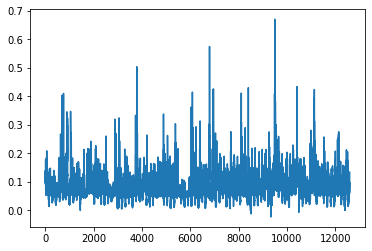

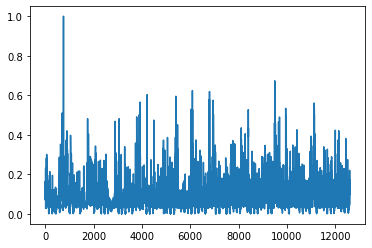

In [37]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])

In [ ]:
import statistics
df_forecats_columns = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2',
                                   'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6',
                                   'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9',
                                   'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
                                   'Visibility', 'Tdewpoint']

columns = list(df_forecats_columns)

final_result = {
    "variable": [],
    "rmse": [],
    "mae": [],
    "mape": [],
    "r2": []
}

measures = model_d1_result
var = measures.groupby("variable")

for col in columns:
    
    var_agr = var.get_group(col)
           
    rmse = round(statistics.mean(var_agr.loc[:,'rmse']),3)
    mape = round(statistics.mean(var_agr.loc[:,'mape']),3)
    mae = round(statistics.mean(var_agr.loc[:,'mae']),3)
    r2 = round(statistics.mean(var_agr.loc[:,'r2']),3)

    final_result["variable"].append(col)
    final_result["rmse"].append(rmse)
    final_result["mape"].append(mape)
    final_result["mae"].append(mae)
    final_result["r2"].append(r2)
        
    #print(f'Results: {(col,rmse,mae,r2)}')
        
        
final_measures = round(pd.DataFrame(final_result),3)